In [7]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax

import numpy as np

import tensorflow_probability.substrates.jax as tfp

import matplotlib.pyplot as plt

from nets import *

In [8]:
def fill_diagonal(a, val):
  assert a.ndim >= 2
  i, j = jnp.diag_indices(min(a.shape[-2:]))
  return a.at[..., i, j].set(val)

In [9]:
from typing import Sequence, Any
Array = Any

import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn


class MLP(nn.Module):
  features: Sequence[int]

  @nn.compact
  def __call__(self, x):
    for feat in self.features[:-1]:
      x = nn.elu(nn.Dense(feat)(x))
    x = nn.Dense(self.features[-1])(x)
    return x

In [10]:
# start model 

fishnet = Fishnet(jnp.ones(n_params,), 
                n_hidden_fisher=[50,50,50], 
                n_hidden_score=[50,50,50],
                n_inputs=n_inputs,
                priorCinv = jnp.eye(n_params),
                n_parameters=n_params)

# initialize all the weights
w_fishnet = fishnet.init(model_key, jnp.ones((n_d,n_inputs)))


NameError: name 'n_params' is not defined

# do a regression scheme
load in Viraj's data and standardize for the network. we'll pad the input sets with zeros, up to $N_{\rm halo}=120$. Parameter combinations that result in fewer halos for the population will be automatically downweighted in the inference

In [13]:
import pickle
from astropy.table import Table
from astropy.cosmology import Planck15

# read in the pickle which contains a list of dictionaries 
with open('lucas_variations_crudeLH_10000_allz0props.hdf5','rb') as f:
    dat = pickle.load(f)

UnpicklingError: invalid load key, 'H'.

In [16]:
import h5py

In [18]:
f = h5py.File('lucas_variations_crudeLH_10000_allz0props.hdf5')

In [23]:
np.array(f['data']

array([(b'0', 0.,  8.98630134e-02, 0.10407099, 0., 1.39836457e-02, 1.60544743,   44828.42275558, 3.51245917e-01, 8.62156901e+09, 0., -2.83045768e-15, 4.14333344e-03,  58.02017244, 6.48174996e+07, 5.50189962e+08,  52.31122029, 0.10179007, 8.28666687e-05, 3.64993884e+07, 0.88961273, -0.93937752, 22.14627139,    0.33567164, 8.39340278e+04, inf, 4.25292553e-05, 1.57975540e-06, inf, 0.80679793, 6.31830767e-06, 8.28896984e+36, -2.3920655 , -0.13653622, 132.78920727, 13.7976159, inf, 0.3122146 , 1.40325372e+38, 4.34003567e-06, 4.31200820e-04, 7.79221669e+54, 0.00031037, 6.82762566e+53, 1.68452297e+10, 4.76998717e-05, -7.31573093e-02, 0, 0.10577521,  511616.77818722, 1.39833844e+06, 1.87061372e+46, 0.5, 0.0022996 , 0.00254156,  35.33698606, 1.33644579e+38, 0.02074267, 9.79949810e+04,  7.10945413e+54,  990.,  59., 210., 1., 0.),
       (b'0', 0., -6.86022398e-01, 0.10391438, 0., 9.95378097e-05, 1.61047312,   45172.51307458, 2.48047900e-03, 8.62156901e+09, 0., -2.83045768e-15, 6.83357559e-03,  5

In [369]:
data_ = np.zeros((len(dat), 120, 3))

theta_ = np.zeros((len(dat), 4))
for i,d in enumerate(dat):
    num_halos = d["z0_Mvir"].shape[0]
    data_[i, :num_halos, 0] = d["z0_Mstar"] / d["z0_Mvir"]
    data_[i, :num_halos, 1] = np.log10(d["z0_Mstar"])
    data_[i, :num_halos, 2] = np.log10(d["z0_Mvir"])
    
    theta_[i, :] = np.stack([d['etaM_A'],
                             d['etaM_alpha0'],
                             #d['tdep_A'],
                             #d['tdep_alpha0'],
                             #d['tdep_beta'],
                             d['etaE_A'],
                             d['etaE_alpha0']])
    
data_full = data_.copy()
theta_full = theta_.copy()

In [370]:
data_full.shape

(5000, 120, 3)

In [371]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0.1, 1.0))

theta_full = scaler.fit_transform(theta_full)

#scaler2 = MinMaxScaler(feature_range=(0.1, 1.0))

#data_ = scaler2.fit_transform(data_.reshape(-1, 4)).reshape(-1, 120, 4)

In [372]:
theta_.shape

(5000, 4)

In [373]:
# train the network for iid data
key = jax.random.PRNGKey(0)

model = FishnetDeepset(jnp.ones(4,), 
                n_hidden_fisher=[128,128], 
                n_hidden_score=[128,128],
                n_hidden_globals=[50,50],
                n_inputs=3,
                n_parameters=4)

w = model.init(key, jnp.ones((120,3)))

mle, score, F = model.apply(w, jnp.ones((120,3)))

In [374]:
mle

Array([ 0.14247657,  0.31609532, -1.0040442 , -0.07213133], dtype=float32)

In [375]:
np.linalg.det(F)

5.6389017

In [376]:
n_train = 4000
data_ = jnp.array(data_full)[:n_train]
theta_ = jnp.array(theta_full)[:n_train]

data_test = jnp.array(data_full)[n_train:]
theta_test = jnp.array(theta_full)[n_train:]


In [377]:
batch_size = 200

data_ = data_.reshape(-1, batch_size, 120, 3)
theta_ = theta_.reshape(-1, batch_size, 4)

In [378]:
@jax.jit
def kl_loss(w, x_batched, theta_batched):

    def fn(x, theta):
       mle,score,F = model.apply(w, x)
       return mle, F
    
    mle, F = jax.vmap(fn)(x_batched, theta_batched)

    return -jnp.mean(-0.5 * jnp.einsum('ij,ij->i', (theta_batched - mle), \
                                             jnp.einsum('ijk,ik->ij', F, (theta_batched - mle))) \
                                                  + 0.5*jnp.log(jnp.linalg.det(F)), axis=0)

In [379]:
kl_loss(w, data_[10], theta_[10])

Array(9.553167, dtype=float32)

In [380]:
from tqdm import tqdm
import optax
tx = optax.adam(learning_rate=1e-4)
opt_state = tx.init(w)
loss_grad_fn = jax.value_and_grad(kl_loss)


batch_size = 200
epochs = 1000


In [381]:
def body_fun(i, inputs):
    w,loss_val, opt_state = inputs
    x_samples = _data[i]
    y_samples = _theta[i]

    loss_val, grads = loss_grad_fn(w, x_samples, y_samples)
    updates, opt_state = tx.update(grads, opt_state)
    w = optax.apply_updates(w, updates)
    
    return w, loss_val, opt_state

In [382]:
data_.shape

(20, 200, 120, 3)

In [430]:
key = jax.random.PRNGKey(999)

losses = jnp.zeros(epochs)

loss_val = 0.


lower = 0
upper = n_train // batch_size

pbar = tqdm(range(epochs), leave=True, position=0)

for j in pbar:
      key,rng = jax.random.split(key)

      # shuffle data every epoch
      randidx = jax.random.shuffle(key, jnp.arange(theta_.reshape(-1, 4).shape[0]))
      _data = data_.reshape(-1, 120, 3)[randidx].reshape(batch_size, -1, 120, 3)
      _theta = theta_.reshape(-1, 4)[randidx].reshape(batch_size, -1, 4)

      inits = (w, loss_val, opt_state)

      w, loss_val, opt_state = jax.lax.fori_loop(lower, upper, body_fun, inits)

      losses = losses.at[j].set(loss_val)
      #val_losses.append(val_loss)
      pbar.set_description('epoch %d loss: %.5f'%(j, loss_val))

  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/anaconda3/lib/python3.8/site-packages/jax/_src/random.py:458: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)
epoch 999 loss: -7.58533: 100%|██████████| 1000/1000 [02:44<00:00,  6.10it/s]


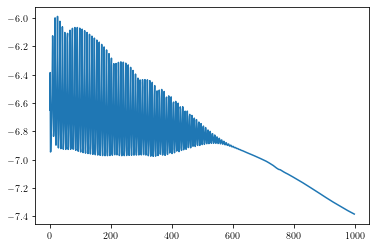

In [418]:
plt.plot(losses)

In [431]:
data_.shape

(20, 200, 120, 3)

In [419]:
_app = lambda d: model.apply(w, d)

mle_pred,_,F_pred = jax.vmap(_app)(data_test.reshape(-1, 120, 3)[:])

In [420]:
params = [r'$\eta_{M_A}$', r'$\eta_{M_{\alpha_0}}$', r'$\eta_{E_A}$', r'$\eta_{E_{\alpha_0}}$']

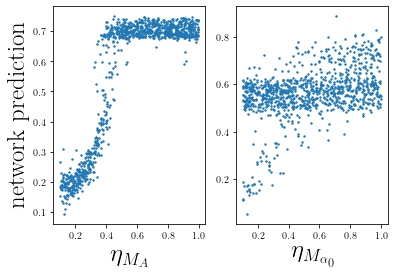

Text(0.5, 0, '$\\eta_{E_{\\alpha_0}}$')

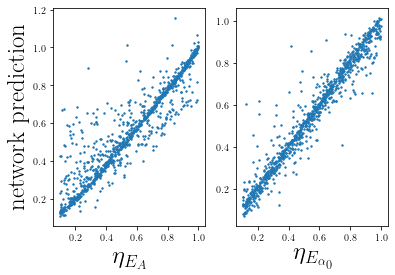

In [421]:
plt.subplot(121)
plt.scatter(theta_test.reshape(-1,4)[:, 0], mle_pred[:, 0], s=2)
plt.xlabel(params[0], fontsize=25)
plt.ylabel('network prediction', fontsize=25)


plt.subplot(122)
plt.scatter(theta_test.reshape(-1,4)[:, 1], mle_pred[:, 1], s=2)
plt.xlabel(params[1], fontsize=25)
plt.show()

plt.subplot(121)
plt.scatter(theta_test.reshape(-1,4)[:, 2], mle_pred[:, 2], s=2)
plt.ylabel('network prediction', fontsize=25)
plt.xlabel(params[2], fontsize=25)

plt.subplot(122)
plt.scatter(theta_test.reshape(-1,4)[:, 3], mle_pred[:, 3], s=2)

plt.xlabel(params[3], fontsize=25)



In [422]:
F_pred.shape

(1000, 4, 4)

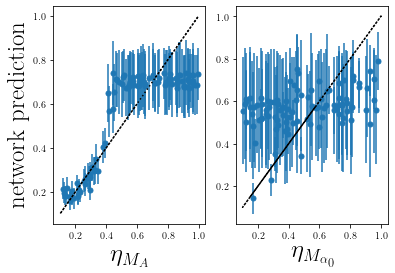

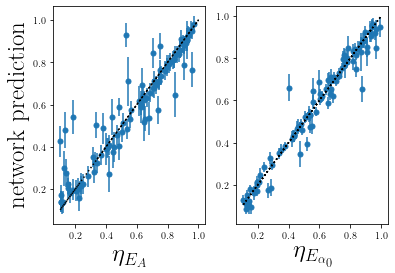

In [429]:
skip = 10

plt.subplot(121)
ind = 0
plt.errorbar(theta_test.reshape(-1,4)[::skip, ind], mle_pred[::skip, ind], 
             yerr=1./np.sqrt(F_pred[::skip, ind, ind]), fmt='o', markersize=5)

plt.plot(theta_test.reshape(-1,4)[:, ind], theta_test.reshape(-1,4)[:, ind], color='k', ls=':', zorder=10)
plt.xlabel(params[ind], fontsize=25)
plt.ylabel('network prediction', fontsize=25)


plt.subplot(122)
ind=1
plt.errorbar(theta_test.reshape(-1,4)[::skip, ind], mle_pred[::skip, ind], 
             yerr=1./(np.sqrt(F_pred[::skip, ind, ind])), fmt='o', markersize=5)
plt.plot(theta_test.reshape(-1,4)[:, ind], theta_test.reshape(-1,4)[:, ind], color='k', ls=':', zorder=10)

plt.xlabel(params[ind], fontsize=25)
plt.show()


plt.subplot(121)
ind=2
plt.errorbar(theta_test.reshape(-1,4)[::skip, ind], mle_pred[::skip, ind], 
             yerr=1./np.sqrt(F_pred[::skip, ind, ind]), fmt='o', markersize=5)
plt.plot(theta_test.reshape(-1,4)[:, ind], theta_test.reshape(-1,4)[:, ind], color='k', ls=':', zorder=10)

plt.xlabel(params[ind], fontsize=25)
plt.ylabel('network prediction', fontsize=25)

plt.subplot(122)
ind=3
plt.errorbar(theta_test.reshape(-1,4)[::skip, ind], mle_pred[::skip, ind], yerr=1./np.sqrt(F_pred[::skip, ind, ind]), fmt='o', markersize=5)
plt.plot(theta_test.reshape(-1,4)[:, ind], theta_test.reshape(-1,4)[:, ind], color='k', ls=':', zorder=10)

plt.xlabel(params[ind], fontsize=25)
plt.show()


In [424]:
from chainconsumer import ChainConsumer

params = [r'$\eta_{M_A}$', r'$\eta_{M_{\alpha_0}}$', r'$\eta_{E_A}$', r'$\eta_{E_{\alpha_0}}$']

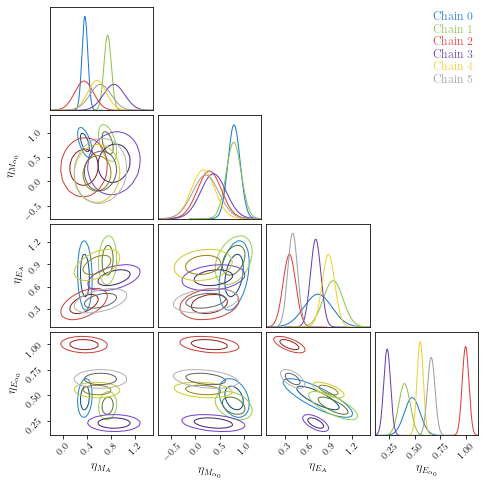

In [425]:
cs = ChainConsumer()

for i in [3, 59, 300, 230, 1997, 42]:


    cs.add_covariance(theta_.reshape(-1, 4)[i], np.linalg.inv(F_pred[i]), parameters=params) #, color=corner_colors[0])

cs.configure(usetex=True)
cs.plotter.plot((7,7))

plt.show()

In [ ]:
# see what fishnets says about behroozi data
# with noise model 